In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cap = cv2.VideoCapture('Jump.avi')
num_frames=0
ret=True
while(ret==True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    num_frames=num_frames+1
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #frame.shape
        
print(num_frames)

128


In [3]:
cap = cv2.VideoCapture('Jump.avi')
ret,frame=cap.read()

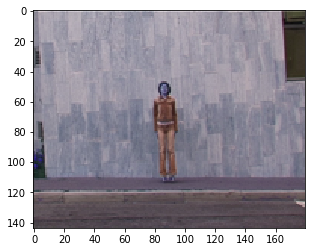

In [4]:
plt.imshow(frame)


In [5]:
shape = frame.shape

In [6]:
shape

(144, 180, 3)

In [7]:
type(frame)

numpy.ndarray

In [8]:
frame

array([[[161, 162, 166],
        [169, 168, 177],
        [162, 158, 168],
        ...,
        [107, 107,  88],
        [103, 102,  86],
        [102, 101,  86]],

       [[132, 131, 140],
        [136, 134, 147],
        [134, 129, 142],
        ...,
        [ 71,  72,  52],
        [ 67,  67,  51],
        [ 66,  65,  50]],

       [[135, 134, 144],
        [136, 133, 147],
        [140, 135, 149],
        ...,
        [ 71,  72,  52],
        [ 69,  68,  52],
        [ 66,  65,  50]],

       ...,

       [[ 71,  66,  70],
        [ 73,  68,  73],
        [ 71,  65,  72],
        ...,
        [ 87,  75,  83],
        [ 81,  70,  79],
        [ 76,  65,  74]],

       [[ 81,  76,  80],
        [ 74,  69,  73],
        [ 68,  63,  67],
        ...,
        [ 77,  65,  73],
        [ 73,  63,  70],
        [ 71,  60,  67]],

       [[ 82,  77,  81],
        [ 74,  69,  72],
        [ 75,  70,  74],
        ...,
        [ 73,  62,  68],
        [ 77,  67,  73],
        [ 77,  67,  73]]

In [9]:
K=4

In [10]:
parameters = np.zeros((shape[0],shape[1],K*4 + K))
alpha = 0.001 #To update weight 
#K gaussians, 1 parameter for sigma, 3 for mu for each of the gaussians and 4 parameters for the weights

In [11]:
import numpy.matlib as nlib
parameters[:,:,16:20]=1/K #Setting initial weights
frame = frame/255.0 #Normalise 1st frame
parameters[:,:,0]=15#Standard deviation is one
parameters[:,:,4]=15
parameters[:,:,8]=15
parameters[:,:,12]=15#Standard deviation is one for first frame
parameters[:,:,1:4]=frame#Mean value is just pixel value for first frame
parameters[:,:,5:8]=frame
parameters[:,:,9:12]=frame
parameters[:,:,13:16]=frame

In [12]:
#Gaussian function
def Gaussian(mu,sigmasquare,x):
    #mu and x are 1*3
    #a = np.transpose(x-mu)
    #siginv = (1/sigmasquare)*np.array([[1,0,0],[0,1,0],[0,0,1]])
    #b = np.matmul(a,siginv)
    #b = np.matmul(b,x-mu)
    b = x-mu
    b = (b[0]*b[0]+b[1]*b[1]+b[2]*b[2])
    b = b/sigmasquare
    b = b*(-1/2)
    b = np.exp(b)
    b = b/np.power(2*22/7,1.5)
    sigma = np.sqrt(sigmasquare)
    b = b/(sigma*sigma*sigma)
    fg=0
    if(x[0]>mu[0]+2.5*sigma):
        fg=fg+1
    if(x[1]>mu[1]+2.5*sigma):
        fg=fg+1
    if(x[2]>mu[2]+2.5*sigma):
        fg=fg+1
    if(x[0]<mu[0]-2.5*sigma):
        fg=fg+1
    if(x[1]<mu[1]-2.5*sigma):
        fg=fg+1
    if(x[2]<mu[2]-2.5*sigma):
        fg=fg+1
    if(fg>=2):
        fg=1
    else:
        fg=0
    b = alpha*b
    return b,fg

In [13]:
a,b = Gaussian(np.array([[0],[0],[0]]),1,np.array([[1.3],[3.5],[5.6]]))
print(a,b)

[9.24055444e-15] 1


In [14]:
#Parameter updation and backgroud detection using rest of the frames
k=0
#while(ret==True):
while(k<=12):
    ret, frame = cap.read()
    frame = frame/255.0
    k=k+1
    foreground = np.zeros((shape[0],shape[1]))#Full black
    print(k)
    for i in range(shape[0]):
        for j in range(shape[1]):
            #Getting details of current frame with past parameters
            ro1,fg1 = Gaussian(np.transpose(parameters[i,j,1:4]),parameters[i,j,0],np.transpose(frame[i,j,:]))
            ro2,fg2 = Gaussian(np.transpose(parameters[i,j,5:8]),parameters[i,j,4],np.transpose(frame[i,j,:]))
            ro3,fg3 = Gaussian(np.transpose(parameters[i,j,9:12]),parameters[i,j,8],np.transpose(frame[i,j,:]))
            ro4,fg4 = Gaussian(np.transpose(parameters[i,j,13:16]),parameters[i,j,12],np.transpose(frame[i,j,:]))
            prob = parameters[i,j,16]*ro1+parameters[i,j,17]*ro2+parameters[i,j,18]*ro3+parameters[i,j,19]*ro4
            prob = prob/alpha
            if(prob>0.5):
                foreground[i,j]=1
            #Updating weights
            if(fg1>=2):
                parameters[i,j,16] = (1-alpha)*parameters[i,j,16]+(alpha)
            else:
                parameters[i,j,16] = (1-alpha)*parameters[i,j,16]
            if(fg2>=2):
                parameters[i,j,17] = (1-alpha)*parameters[i,j,17]+(alpha)
            else:
                parameters[i,j,17] = (1-alpha)*parameters[i,j,17]
            if(fg3>=2):
                parameters[i,j,18] = (1-alpha)*parameters[i,j,18]+(alpha)
            else:
                parameters[i,j,18] = (1-alpha)*parameters[i,j,18]
            if(fg4>=2):
                parameters[i,j,19] = (1-alpha)*parameters[i,j,19]+(alpha)
            else:
                parameters[i,j,19] = (1-alpha)*parameters[i,j,19]
            #Updating mu
            parameters[i,j,1:4] = (1-ro1)*parameters[i,j,1:4] + ro1*frame[i,j,:]
            parameters[i,j,5:8] = (1-ro2)*parameters[i,j,5:8] + ro2*frame[i,j,:]
            parameters[i,j,9:12] = (1-ro3)*parameters[i,j,9:12] + ro3*frame[i,j,:]
            parameters[i,j,13:16] = (1-ro4)*parameters[i,j,13:16] + ro4*frame[i,j,:]
            #Updating sigma
            parameters[i,j,0] = (1-ro1)*parameters[i,j,0] + ro1*np.matmul((frame[i,j,:]-parameters[i,j,1:4]),np.transpose(frame[i,j,:]-parameters[i,j,1:4]))
            parameters[i,j,4] = (1-ro2)*parameters[i,j,4] + ro2*np.matmul((frame[i,j,:]-parameters[i,j,5:8]),np.transpose(frame[i,j,:]-parameters[i,j,5:8]))
            parameters[i,j,8] = (1-ro3)*parameters[i,j,8] + ro3*np.matmul((frame[i,j,:]-parameters[i,j,9:12]),np.transpose(frame[i,j,:]-parameters[i,j,9:12]))
            parameters[i,j,12] = (1-ro4)*parameters[i,j,12] + ro4*np.matmul((frame[i,j,:]-parameters[i,j,13:16]),np.transpose(frame[i,j,:]-parameters[i,j,13:16]))
            #if(k%20==0):
                #plt.imshow(foreground)
            if(k>=22):
                break
            

1
2
3
4
5
6
7
8
9
10
11
12
13


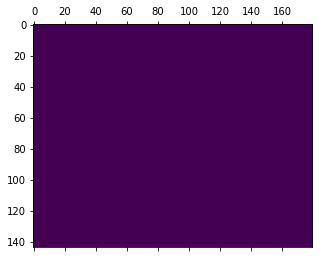

In [15]:
plt.matshow(foreground)